## Import des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('default', category=UserWarning, module='pkg_resources')

In [2]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
    cross_val_predict,
)
from sklearn.metrics import r2_score, mean_absolute_error , root_mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,FunctionTransformer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor


In [3]:

bc_after_eda = pd.read_csv("data/bc_after_eda.csv", index_col='Unnamed: 0',dtype={'NumberofFloors':float})
select_columns = ['LargestPropertyUseTypeGFA', 'ListOfAllPropertyUseTypes', 'SecondLargestPropertyUseTypeGFA', 'FirstUseType', 'SecondLargestPropertyUseType', 'YearBuilt', 'NumberofFloors', 'NumberofBuildings','Latitude', 'Longitude', 'Neighborhood',
                                     'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)','SiteEUI(kBtu/sf)','SumLargestGFA']
bc_after_eda = bc_after_eda[select_columns]
bc_after_eda

,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,SecondLargestPropertyUseTypeGFA,FirstUseType,SecondLargestPropertyUseType,YearBuilt,NumberofFloors,NumberofBuildings,Latitude,Longitude,Neighborhood,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEUI(kBtu/sf),SumLargestGFA
0,88434.0,Hotel,0.0,Hotel,NaN,1927,12.0,1.0,47.61220,-122.33799,DOWNTOWN,7.226362e+06,3.946027e+06,1.276453e+06,2003882.00,81.699997,88434.0
1,83880.0,"Hotel, Parking, Restaurant",15064.0,Hotel,Parking,1996,11.0,1.0,47.61317,-122.33393,DOWNTOWN,8.387933e+06,3.242851e+06,5.145082e+06,0.00,94.800003,103566.0
2,756493.0,Hotel,0.0,Hotel,NaN,1969,41.0,1.0,47.61393,-122.33810,DOWNTOWN,7.258702e+07,4.952666e+07,1.493800e+06,21566554.00,96.000000,756493.0
3,61320.0,Hotel,0.0,Hotel,NaN,1926,10.0,1.0,47.61412,-122.33664,DOWNTOWN,6.794584e+06,2.768924e+06,1.811213e+06,2214446.25,110.800003,61320.0
4,123445.0,"Hotel, Parking, Swimming Pool",68009.0,Hotel,Parking,1980,18.0,1.0,47.61375,-122.34047,DOWNTOWN,1.417261e+07,5.368607e+06,8.803998e+06,0.00,114.800003,191454.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294.0,Office,0.0,Office,NaN,1990,1.0,1.0,47.56722,-122.31154,GREATER DUWAMISH,8.497457e+05,5.242709e+05,3.254750e+05,0.00,69.099998,12294.0
3372,16000.0,Other - Recreation,0.0,Other,NaN,2004,1.0,1.0,47.59625,-122.32283,DOWNTOWN,9.502762e+05,3.965461e+05,5.537300e+05,0.00,59.400002,16000.0
3373,7583.0,"Fitness Center/Health Club/Gym, Other - Recrea...",5574.0,Other,Fitness Center/Health Club/Gym,1974,1.0,1.0,47.63644,-122.35784,MAGNOLIA / QUEEN ANNE,5.765898e+06,1.792159e+06,3.973739e+06,0.00,438.200012,13157.0
3374,6601.0,"Fitness Center/Health Club/Gym, Food Service, ...",6501.0,Mixed Use Property,Fitness Center/Health Club/Gym,1989,1.0,1.0,47.52832,-122.32431,GREATER DUWAMISH,7.194712e+05,3.488702e+05,3.706010e+05,0.00,51.000000,13586.0


## Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

#### Modes énergétiques

In [4]:
bc_after_eda['UseGas'] = (bc_after_eda['NaturalGas(kBtu)'].notna()) & (bc_after_eda['NaturalGas(kBtu)'] != 0)
bc_after_eda['UseSteam'] = (bc_after_eda['SteamUse(kBtu)'].notna()) & (bc_after_eda['SteamUse(kBtu)'] != 0)
bc_after_eda['UseElectricity'] = (bc_after_eda['Electricity(kBtu)'].notna()) & (bc_after_eda['Electricity(kBtu)'] != 0)


#### distance du centre ville

In [5]:
def haversine(lat1, lon1, lat2, lon2):
    # Entrées: Series -> conversion séparée
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 3958.8
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [6]:
seattle_lat, seattle_lon = 47.6085965, -122.5049456

bc_after_eda['CityDistance'] = haversine(
    bc_after_eda['Latitude'], bc_after_eda['Longitude'],
    seattle_lat, seattle_lon
).round(2)
bc_after_eda['CityDistance'].describe()

count    1628.000000
mean        8.662082
std         1.414878
min         4.960000
25%         7.797500
50%         8.360000
75%         9.430000
max        15.200000
Name: CityDistance, dtype: float64

#### Utilisation multiple

In [7]:
bc_after_eda['MultipleUseType'] = bc_after_eda['ListOfAllPropertyUseTypes'].str.count('s')+1
bc_after_eda['MultipleUseType'].value_counts()

MultipleUseType
1    967
2    529
3     92
4     32
6      3
7      2
5      2
8      1
Name: count, dtype: int64

In [8]:
print(bc_after_eda.shape)
print(bc_after_eda.columns)

(1628, 22)
Index(['LargestPropertyUseTypeGFA', 'ListOfAllPropertyUseTypes',
       'SecondLargestPropertyUseTypeGFA', 'FirstUseType',
       'SecondLargestPropertyUseType', 'YearBuilt', 'NumberofFloors',
       'NumberofBuildings', 'Latitude', 'Longitude', 'Neighborhood',
       'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SumLargestGFA', 'UseGas',
       'UseSteam', 'UseElectricity', 'CityDistance', 'MultipleUseType'],
      dtype='object')


## Split train/test

In [9]:
#predict_values = ['LargestPropertyUseTypeGFA', 'FirstUseType','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'MultipleUseType', 'UseSteam', 'UseGas',
predict_values = [ 'FirstUseType','SecondLargestPropertyUseType', 'SumLargestGFA', 'MultipleUseType', 'UseSteam', 'UseGas',
       'NumberofFloors', 'NumberofBuildings', 'CityDistance', 'Neighborhood','YearBuilt']
X = bc_after_eda[predict_values]
target = 'SiteEnergyUse(kBtu)'
y = bc_after_eda[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [10]:
print("Index X_train avant pipeline :", X_train.index.equals(y_train.index))


Index X_train avant pipeline : True


## Finalisation des features

In [11]:
# ========================
# ÉTAPE 1: PREPROCESSING PERSONNALISÉ 
# ========================

from ocde_p6.preprocessing.transformer import fix_floors_and_discretize

# ========================
# ÉTAPE 2: PIPELINE COMPLET
# ========================

# Colonnes après votre preprocessing
categorical_features = ['FirstUseType', 'SecondLargestPropertyUseType', 
                       'Neighborhood','AgeCategory','EnergyEra','HeightCategory']  


numerical_features = ['AgeProperty','CityDistance', 
                      'MultipleUseType', 'NumberofBuildings']

# Pipeline complet
full_pipeline = Pipeline([
    # Étape 1: Preprocessing personnalisé
    ('preprocessing', FunctionTransformer(fix_floors_and_discretize, validate=False)),
    
    # Étape 2: Encodage + Normalisation
    ('encoder', ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features),
        ('num', StandardScaler(), numerical_features)
    ], remainder='passthrough'))
])

# ========================
# ÉTAPE 3: APPLICATION 
# ========================

# Fit sur train et transform train/test
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# ========================
# ÉTAPE 4: CRÉER  DataFrames _final
# ========================

# Récupérer les noms des colonnes
onehot = full_pipeline.named_steps['encoder'].named_transformers_['cat']
onehot_names = onehot.get_feature_names_out(categorical_features)
num_names = [f"scaled_{col}" for col in numerical_features]

# Colonnes restantes (passthrough)
all_cols_after_preprocessing = fix_floors_and_discretize(X_train).columns
remaining_cols = [col for col in all_cols_after_preprocessing 
                 if col not in categorical_features + numerical_features]

# Noms finaux
final_feature_names = list(onehot_names) + num_names + remaining_cols

# Vos DataFrames finaux
X_train_final = pd.DataFrame(X_train_transformed, columns=final_feature_names,index=X_train.index )
X_test_final = pd.DataFrame(X_test_transformed, columns=final_feature_names,index=X_test.index)

# Conversion en numérique
for col in X_train_final.columns:
    X_train_final[col] = pd.to_numeric(X_train_final[col], errors='coerce')
    X_test_final[col] = pd.to_numeric(X_test_final[col], errors='coerce')


print(f"✅ Pipeline terminé!")
print(f"Shape finale: Train {X_train_final.shape}, Test {X_test_final.shape}")


✅ Pipeline terminé!
Shape finale: Train (1302, 112), Test (326, 112)


/home/yves/.cache/pypoetry/virtualenvs/ocde-p6-qTWNOnCB-py3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
print("Index X_train_final après pipeline :", X_train_final.index.equals(y_train.index))

Index X_train_final après pipeline : True


In [13]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 232 to 1973
Columns: 112 entries, FirstUseType_Automobile Dealership to building_volume
dtypes: bool(2), float64(110)
memory usage: 1.1 MB


## Comparaison des modèles

In [14]:
# CODE COMPARAISON DES MODELES
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
models = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
}

print("="*80)
print("COMPARAISON DES MODÈLES (Validation Croisée 5-fold)")
print("="*80)

# Dictionnaire de résultats
cv_results = {}

# Scoring pour cross_validate (optionnel, juste pour info)
scoring = {
    'r2': 'r2',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

for name, model in models.items():
    print(f"\nÉvaluation de {name}...")
    
    # Pipeline complet
    full_estimator = Pipeline([
        ('preprocess', full_pipeline.named_steps['preprocessing']),
        ('encode_scale', full_pipeline.named_steps['encoder']),
        ('model', model)
    ])
    
    # Cross-validation sur échelle LOG (pour R² et RMSE log)
    scores = cross_validate(
        full_estimator, X_train, y_train_log, 
        cv=5, scoring=scoring, n_jobs=-1, return_train_score=True
    )
    
    # ✓✓✓ Récupérer les prédictions cross-validées (en échelle log) ✓✓✓
    y_pred_log_cv = cross_val_predict(
        full_estimator, X_train, y_train_log, cv=5, n_jobs=-1
    )
    
    # ✓✓✓ RETRANSFORMER EN ÉCHELLE ORIGINALE ✓✓✓
    y_pred_kbtu_cv = np.expm1(y_pred_log_cv)
    y_train_original = np.expm1(y_train_log)
    
    # Calculer les métriques sur échelle ORIGINALE
    rmse_kbtu = root_mean_squared_error(y_train_original, y_pred_kbtu_cv)
    mae_kbtu = mean_absolute_error(y_train_original, y_pred_kbtu_cv)
    mape_kbtu = mean_absolute_percentage_error(y_train_original, y_pred_kbtu_cv)
    r2_kbtu = r2_score(y_train_original, y_pred_kbtu_cv)
    
    # Stocker les résultats en échelle ORIGINALE
    cv_results[name] = {
        'R2': r2_kbtu,
        'RMSE_kBtu': rmse_kbtu,
        'MAE_kBtu': mae_kbtu,
        'MAPE': mape_kbtu,
        'RMSE_log': -scores['test_neg_root_mean_squared_error'].mean()  # Pour info
    }
    
    # Affichage
    print(f"  R² (échelle originale): {r2_kbtu:.4f}")
    print(f"  RMSE: {rmse_kbtu:,.0f} kBtu")
    print(f"  MAE: {mae_kbtu:,.0f} kBtu")
    print(f"  MAPE: {mape_kbtu:.4f} ({mape_kbtu*100:.2f}%)")
    print(f"  [RMSE échelle log: {cv_results[name]['RMSE_log']:.4f}]")

# Affichage du tableau récapitulatif
print("\n" + "="*80)
print("RÉSUMÉ COMPARATIF (sur échelle originale kBtu)")
print("="*80)

import pandas as pd
df_results = pd.DataFrame(cv_results).T
df_results = df_results.sort_values('R2', ascending=False)

# Formatter pour affichage
df_display = df_results.copy()
df_display['RMSE_kBtu'] = df_display['RMSE_kBtu'].apply(lambda x: f"{x:,.0f}")
df_display['MAE_kBtu'] = df_display['MAE_kBtu'].apply(lambda x: f"{x:,.0f}")
df_display['MAPE'] = df_display['MAPE'].apply(lambda x: f"{x:.2%}")
df_display['R2'] = df_display['R2'].apply(lambda x: f"{x:.4f}")

print(df_display[['R2', 'RMSE_kBtu', 'MAE_kBtu', 'MAPE']])

# Sélection du meilleur modèle
best_model_name = df_results['R2'].idxmax()
print(f"\n✓ Meilleur modèle: {best_model_name} (R² = {df_results.loc[best_model_name, 'R2']:.4f})")

COMPARAISON DES MODÈLES (Validation Croisée 5-fold)

Évaluation de DummyRegressor...
  R² (échelle originale): -0.0641
  RMSE: 19,350,576 kBtu
  MAE: 6,594,411 kBtu
  MAPE: 1.4363 (143.63%)
  [RMSE échelle log: 1.2476]

Évaluation de LinearRegression...
  R² (échelle originale): -183.6434
  RMSE: 254,902,665 kBtu
  MAE: 13,497,786 kBtu
  MAPE: 0.7274 (72.74%)
  [RMSE échelle log: 0.7635]

Évaluation de SVR...
  R² (échelle originale): 0.2795
  RMSE: 15,923,311 kBtu
  MAE: 4,933,733 kBtu
  MAPE: 0.8522 (85.22%)
  [RMSE échelle log: 0.8897]

Évaluation de GradientBoosting...
  R² (échelle originale): 0.6050
  RMSE: 11,789,191 kBtu
  MAE: 3,475,094 kBtu
  MAPE: 0.5519 (55.19%)
  [RMSE échelle log: 0.6332]

Évaluation de RandomForest...
  R² (échelle originale): 0.5488
  RMSE: 12,600,699 kBtu
  MAE: 3,695,933 kBtu
  MAPE: 0.5880 (58.80%)
  [RMSE échelle log: 0.6708]

RÉSUMÉ COMPARATIF (sur échelle originale kBtu)
                         R2    RMSE_kBtu    MAE_kBtu     MAPE
GradientBoostin

### Sauvegarde du meilleur résultat


                       R2   RMSE_kBtu   MAE_kBtu     MAPE  
RandomForest       0.3256  26,240,652  4,442,667   59.65%  
GradientBoosting   0.3103  26,536,335  4,254,263   56.64%  
SVR                0.1251  29,889,086  5,928,491   93.80%  
DummyRegressor    -0.0311  32,447,395  7,452,060  147.00%  
LinearRegression  -7.7848  94,708,167  6,001,406   56.23%

## Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [15]:
# Supposons best_model_name défini précédemment
best_model_name = "GradientBoosting"
#best_model_name = "RandomForest"
def optimize_model(df_X_train,df_y_train, df_X_test, df_y_test):
    print(f"=== OPTIMISATION de {best_model_name} ===")

    if best_model_name == 'RandomForest':
        estimator = RandomForestRegressor(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

    elif best_model_name == 'GradientBoosting':
        estimator = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }

    elif best_model_name == 'LinearRegression':
        estimator = LinearRegression()
        param_grid = {
            'fit_intercept': [True, False],
            'positive': [False, True]
        }

    elif best_model_name == 'SVR':
        estimator = SVR()
        param_grid = {
            'kernel': ['rbf', 'linear', 'poly'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }

    else:
        raise ValueError(f"Modèle non supporté : {best_model_name}")

    # Lancer GridSearchCV
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    gs.fit(df_X_train, df_y_train)

    print("Meilleurs paramètres :", gs.best_params_)
    print("Meilleur score CV (RMSE) :", -gs.best_score_)

    # Évaluation finale
    final_model = gs.best_estimator_
    df_y_pred_log = final_model.predict(df_X_test)
    df_y_pred = np.expm1(df_y_pred_log)

    print("\n=== PERFORMANCE FINALE sur TEST ===")
    print(f"RMSE: {root_mean_squared_error(df_y_test, df_y_pred):.0f}")
    print(f"R²: {r2_score(df_y_test, df_y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(df_y_test, df_y_pred):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(df_y_test, df_y_pred):.4f}")
    return gs
gs = optimize_model(X_train_final,y_train_log,X_test_final,y_test)

=== OPTIMISATION de GradientBoosting ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Meilleur score CV (RMSE) : 0.6227099703778595

=== PERFORMANCE FINALE sur TEST ===
RMSE: 8248860
R²: 0.8157
MAE: 2985202.24
MAPE: 0.5351


### Sauvegarde du meilleur résultat  

=== OPTIMISATION de GradientBoosting ===  
Fitting 5 folds for each of 36 candidates, totalling 180 fits  
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}  
Meilleur score CV (RMSE) : 0.6297311544523687  
  
=== PERFORMANCE FINALE sur TEST ===
RMSE: 9625772  
R²: 0.8412  
MAE: 3294364.14  
MAPE: 0.4591  

/tmp/ipykernel_143597/2310857743.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['combo'] = (


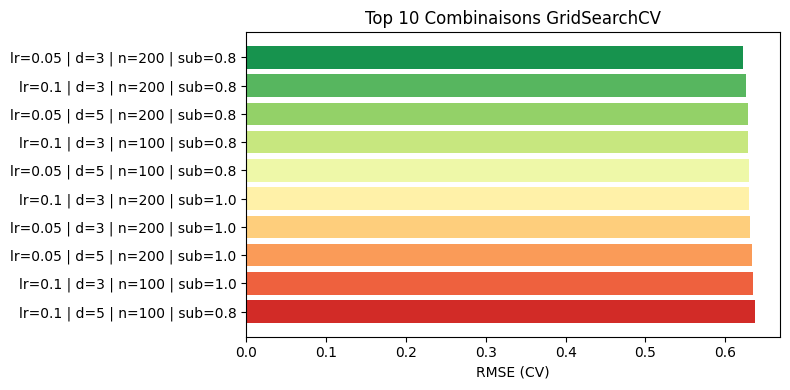

In [16]:
results_df = pd.DataFrame(gs.cv_results_)

# Convertir le score négatif en positif
results_df['mean_rmse'] = -results_df['mean_test_score']


# Trier par performance
results_sorted = results_df.sort_values('mean_rmse')

# Afficher les top 10
fig, ax = plt.subplots(figsize=(8, 4))
top10 = results_sorted.head(10)

# Créer des labels pour chaque combinaison
top10['combo'] = (
    'lr=' + top10['param_learning_rate'].astype(str) + 
    ' | d=' + top10['param_max_depth'].astype(str) +
    ' | n=' + top10['param_n_estimators'].astype(str) +
    ' | sub=' + top10['param_subsample'].astype(str)
)

# Barplot horizontal
colors = sns.color_palette('RdYlGn_r', len(top10))
ax.barh(top10['combo'], top10['mean_rmse'], color=colors)
ax.set_xlabel('RMSE (CV)')
ax.set_title('Top 10 Combinaisons GridSearchCV')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [17]:
np.expm1(0.6297) * y_train.mean()

np.float64(6963667.854702854)

/tmp/ipykernel_143597/1690211730.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['combo'] = (


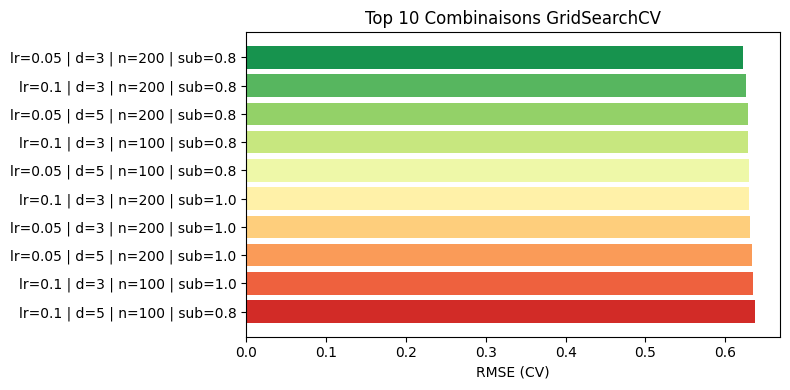

In [18]:
# Trier par performance
results_sorted = results_df.sort_values('mean_rmse')

# Afficher les top 10
fig, ax = plt.subplots(figsize=(8, 4))
top10 = results_sorted.head(10)

# Créer des labels pour chaque combinaison
top10['combo'] = (
    'lr=' + top10['param_learning_rate'].astype(str) + 
    ' | d=' + top10['param_max_depth'].astype(str) +
    ' | n=' + top10['param_n_estimators'].astype(str) +
    ' | sub=' + top10['param_subsample'].astype(str)
)

# Barplot horizontal
colors = sns.color_palette('RdYlGn_r', len(top10))
ax.barh(top10['combo'], top10['mean_rmse'], color=colors)
ax.set_xlabel('RMSE (CV)')
ax.set_title('Top 10 Combinaisons GridSearchCV')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [19]:
best_model = gs.best_estimator_

if best_model_name in ['GradientBoosting','RandomForest']:

    importances = best_model.feature_importances_
    feature_names = X_train_final.columns

    # Affichage du top 10 features les plus importantes
    sorted_idx = importances.argsort()[::-1]
    print("Top 10 features by importance:")
    for idx in sorted_idx[:10]:
        print(f"- {feature_names[idx]}: {importances[idx]:.6f}")

Top 10 features by importance:
- SumLargestGFA: 0.638329
- building_volume: 0.091427
- FirstUseType_Supermarket / Grocery Store: 0.038253
- FirstUseType_Warehouse: 0.037413
- UseGas: 0.024359
- scaled_AgeProperty: 0.018772
- FirstUseType_Distribution Center: 0.018646
- FirstUseType_Other: 0.014692
- FirstUseType_Self-Storage Facility: 0.010820
- FirstUseType_Laboratory: 0.010581


## Colonnes à supprimer

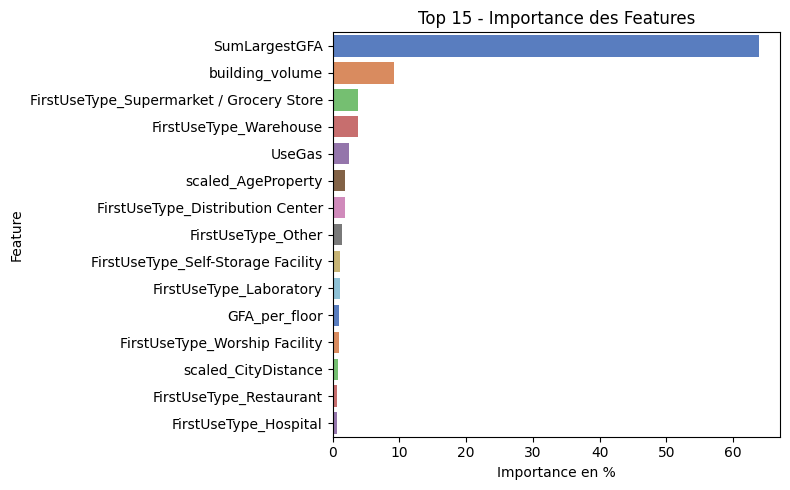

In [20]:
df_importances = pd.DataFrame({
        'feature': feature_names[sorted_idx[:15]],
        'importance': importances[sorted_idx[:15]]
    })

# Visualisation avec seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x=df_importances['importance']*100, y=df_importances['feature'], hue=df_importances['feature'],palette='muted')

plt.title('Top 15 - Importance des Features')
plt.xlabel('Importance en %')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

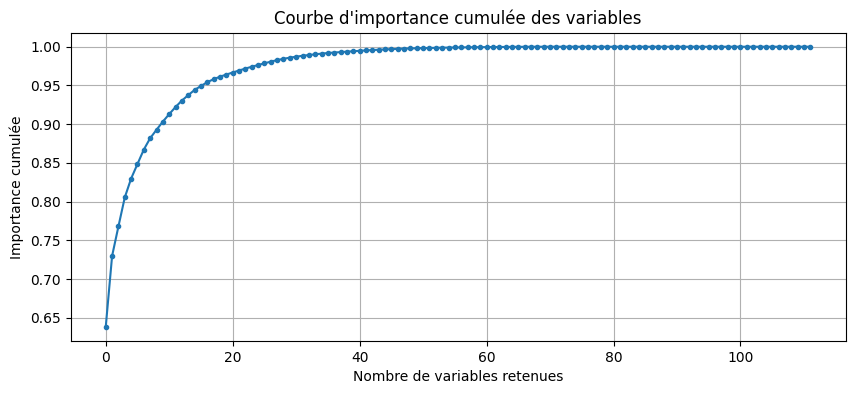

In [21]:
# Supposons model est un RandomForest/GradientBoost entraîné
sorted_importances = pd.Series(best_model.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)

# Cumul
cumul = sorted_importances.cumsum()

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(cumul)), cumul, marker='.')
plt.xlabel('Nombre de variables retenues')
plt.ylabel('Importance cumulée')
plt.title('Courbe d\'importance cumulée des variables')
plt.grid(True)
plt.show()


In [22]:
seuil_importance = sorted_importances[cumul <= 0.99].min()
# Variables à conserver
print(f"Seuil calculé {seuil_importance:.6f}")
selected_features = sorted_importances[sorted_importances >= seuil_importance].index
non_selected_features = [col for col in X_train_final.columns if col not in selected_features]
print(f"{len(selected_features)} variables conservées :")
print("\n".join(selected_features.tolist()))

Seuil calculé 0.000977
33 variables conservées :
SumLargestGFA
building_volume
FirstUseType_Supermarket / Grocery Store
FirstUseType_Warehouse
UseGas
scaled_AgeProperty
FirstUseType_Distribution Center
FirstUseType_Other
FirstUseType_Self-Storage Facility
FirstUseType_Laboratory
GFA_per_floor
FirstUseType_Worship Facility
scaled_CityDistance
FirstUseType_Restaurant
FirstUseType_Hospital
FirstUseType_K-12 School
FirstUseType_Data Center
FirstUseType_Parking
SecondLargestPropertyUseType_Data Center
AgeCategory_Recent
Neighborhood_GREATER DUWAMISH
UseSteam
SecondLargestPropertyUseType_Parking
scaled_NumberofBuildings
FirstUseType_Large Office
SecondLargestPropertyUseType_Laboratory
FirstUseType_Museum
FirstUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)
FirstUseType_Manufacturing/Industrial Plant
Neighborhood_SOUTHWEST
scaled_MultipleUseType
SecondLargestPropertyUseType_Fitness Center/Health Club/Gym
SecondLargestPropertyUseType_Office


In [23]:

selected_cat = "Neighborhood"
sorted_list = selected_features.to_list()
sorted_list.sort()
cut_position = len(selected_cat) +1 

for feat in sorted_list:
    if feat.startswith(selected_cat):
        value = feat[cut_position:]
        print(f"\"{value}\",")


"GREATER DUWAMISH",
"SOUTHWEST",


In [24]:
print(f"{len(non_selected_features)} variables supprimées :")
print("\n".join(non_selected_features))

79 variables supprimées :
FirstUseType_Automobile Dealership
FirstUseType_Bank Branch
FirstUseType_Courthouse
FirstUseType_Financial Office
FirstUseType_Fitness Center/Health Club/Gym
FirstUseType_Food Service
FirstUseType_Hotel
FirstUseType_Library
FirstUseType_Lifestyle Center
FirstUseType_Medical Office
FirstUseType_Mixed Use Property
FirstUseType_Office
FirstUseType_Performing Arts
FirstUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)
FirstUseType_Police Station
FirstUseType_Pre-school/Daycare
FirstUseType_Prison/Incarceration
FirstUseType_Refrigerated Warehouse
FirstUseType_Residential Care Facility
FirstUseType_Retail Store
FirstUseType_Senior Care Community
FirstUseType_Small- and Mid-Sized Office
FirstUseType_Social/Meeting Hall
FirstUseType_Strip Mall
FirstUseType_University
SecondLargestPropertyUseType_Automobile Dealership
SecondLargestPropertyUseType_Bank Branch
SecondLargestPropertyUseType_College/University
SecondLargestPropertyUseType_Convenience Store withou

## Optimisation colonnes réduites

In [25]:
X_train_reduced = X_train_final.drop(columns=non_selected_features).copy()
X_test_reduced = X_test_final.drop(columns=non_selected_features).copy()
gs = optimize_model(X_train_reduced,y_train_log,X_test_reduced,y_test)
final_model = gs.best_estimator_

=== OPTIMISATION de GradientBoosting ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Meilleur score CV (RMSE) : 0.6182913913169065

=== PERFORMANCE FINALE sur TEST ===
RMSE: 7302343
R²: 0.8556
MAE: 2864204.39
MAPE: 0.5237


=== OPTIMISATION de GradientBoosting ===  
Fitting 5 folds for each of 36 candidates, totalling 180 fits  
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}  
Meilleur score CV (RMSE) : 0.6257611663328719  

=== PERFORMANCE FINALE sur TEST ===  
RMSE: 8184578  
R²: 0.8852  
MAE: 3114274.40  
MAPE: 0.4575  

In [26]:
# Reconstruire le pipeline COMPLET (preprocessing + encoding + modèle final)
complete_pipeline = Pipeline([
    ('preprocessing', full_pipeline.named_steps['preprocessing']),
    ('encoder', full_pipeline.named_steps['encoder']),
    ('model', final_model)
])

# FIT le pipeline complet sur les données BRUTES (X_train, pas X_train_reduced)
# Cela permettra au pipeline de "mémoriser" toutes les transformations
complete_pipeline.fit(X_train, y_train_log)

# Vérifier que le pipeline fonctionne
assert hasattr(complete_pipeline, "predict")
y_pred_test = complete_pipeline.predict(X_test)
print(f"Test RMSE: {root_mean_squared_error(y_test_log, y_pred_test):.4f}")

Test RMSE: 0.6201


## Démo

In [72]:
X_demo = {
      "FirstUseType": "Hospital",
      "SecondLargestPropertyUseType": "None",
      "MultipleUseType": 1,
      "SumLargestGFA": 108434.0,
      "UseSteam": True,
      "UseGas": False,
      "NumberofFloors": 12.0,
      "NumberofBuildings": 1.0,
      "CityDistance": 8.5,
      "Neighborhood": "DOWNTOWN",
      "YearBuilt": 2009
    }
df_demo = pd.DataFrame([X_demo])
y_demo = float(complete_pipeline.predict(df_demo)[0])
y_exp = np.expm1(y_demo)
print(f"y_demo : {y_demo}  -  y_exp : {round(y_exp,2)}")

y_demo : 16.1409316777003  -  y_exp : 10230986.65


# Sauvegarde BentoML

In [68]:
import bentoml
bentoml.sklearn.save_model(
    name="building_energy_rf_pipeline",
    model=complete_pipeline,
    signatures={"predict": {"batchable": True}},
    metadata={
        "author": "day811",
        "n_features": len(X_train_reduced.columns),
        "feature_names": list(X_train_reduced.columns)
    },
    
)

Model(tag="building_energy_rf_pipeline:qyigtyfu5ot2wlhq", path="/tmp/bentoml-model-building_energy_rf_pipeline-yu3k9wj2")